# **Facial Emotion Detection**

## **Introduction**

As automated systems become more prevalent, thanks largely to advances in machine learning that allow machines to handle increasingly complex tasks, the need for efficient and accurate communication between humans and machines becomes increasingly important.  Because much of human communication occurs non-verbally, e.g. through gestures and facial expressions, machines need to learn how to interpret non-verbal signals in order to understand what humans want and, often importantly, how they feel.  For example, an automated order taking system should be able to detect when a customer is growing frustrated, so that it can respond accordingly (e.g., by asking if the customer would like human assistance.)<br>
<br>

**Objectives**<br>

The goal of this project is to be develop a model that is able to detect which emotion a person is feeling simply by looking at a picture of their face (i.e., by reading the picture as input.) The current task is limited to one of four emotions (happy, sad, neutral, and surprised), but a good methodology, if found, could be applied to a larger dataset in the future that included additional emotions (e.g., angry, confused, bored, etc.)<br>
<br>

**Key questions**<br>

Some of the key questions that need to be answered include:

1.   What pre-processing, if any, should be performed on the input data?
2.   What type of model should we use (*de novo* or transfer learning CNN)?
3.   What architecture should we use in the model?
4.   What learning parameters should we use?
4.   Where does the model perform poorly, and what could be done to improve that performance?<br>
<br>

**About the data**

The data consists of roughly 20k images of peoples faces.  The images are 48 x 48 pixels, grayscale and have been partitioned into 'test', 'train', and 'validation' sets.  Each image has been labeled with one of four emotions:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Part 1: Exploratory Data Analysis**

**NOTE:**  This work is being conducted in Google Colab using a GPU runtime.  The data has been uploaded to the instance.

### **Import Libraries**

In [19]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import random

# Import Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend

### **Load the data**

In [3]:
# The data has been uploaded to the instance in a zip file
picture_size = 48
path = 'Facial_emotion_images.zip'
folder_path = "Facial_emotion_images/"

# Extract individual images from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

### **Visualize classes**

Humans are good at detecting people's emotional state from their face (though some are better at it than others).  There are a number of things we look at, and an accurate model would likely focus on these same things.  They include: the corners of the mouth, how open or closed the mouth is, whether or not teeth are showing, whether the lips are pursed or relaxed, how open or closed the eyes are, how much squint (from the muscles under the eyes) the eyes show, the position of the eyebrows (raised, relaxed, pointing downward in the middle, etc.), and the state of the forehead (relaxed or furrowed).

Given the complexity of the human face and human emotions, a well-performing model should learn a set of things (rather than a single feature) to associate with each emotion.  For example, happy and surprised might both tend to have open mouths, but surprised faces would have more wide-open eyes.  Similarly, neutral and sad share many similarities, but sad people may have a higher tendency to look away from the camera and their mouths might be slightly more frowned.

#### **Happy**

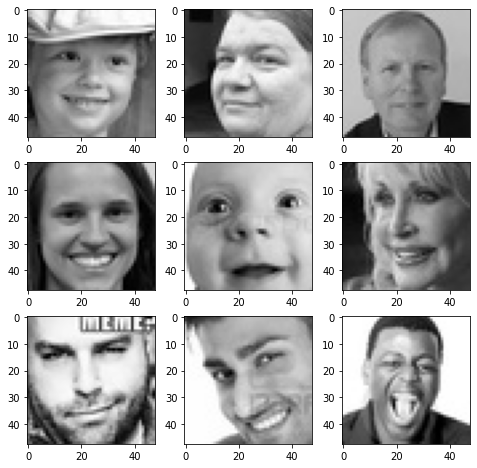

In [4]:
# Create a function to show sample images for an emotion class
def show_images(expression):
  plt.figure(figsize= (8,8))
  for i in range(1, 10, 1):
      plt.subplot(3, 3, i)
      img = load_img(folder_path + "train/" + expression + "/" +
                     os.listdir(folder_path + "train/" + expression)[i],
                     target_size = (picture_size, picture_size))
      plt.imshow(img)   
  plt.show()

# Show happy images
show_images('happy')

**Observations:**

*   Teeth often showing.
*   The muscles below the eyes often push up, making the eye shape less round and sometimes producing creases below the eyes or on the sides.
*   Wide age range.
*   Hats or hair sometimes obscure the forehead.
*   Background sometimes blank, sometimes has features.
*   Subjects are shown from different angles and their gaze is not always at the camera.



#### **Sad**

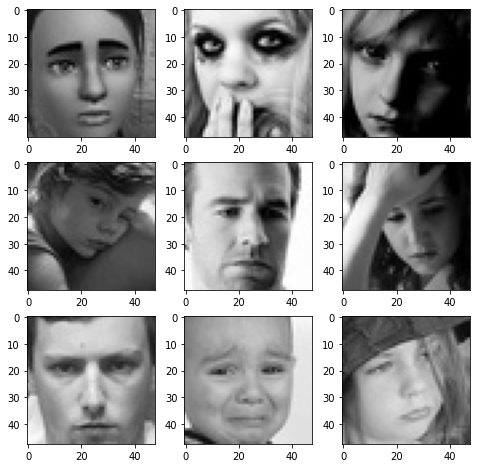

In [ ]:
# Show sad images
show_images('sad')

**Observations:**


*   Mouth often closed.
*   Eyes sometimes closed or looking sideways / down.
*   Eyebrows sometimes angled upward toward center of face.
*   Lips sometimes pursed.
*   Corners of mouth sometimes angled downward.



#### **Neutral**

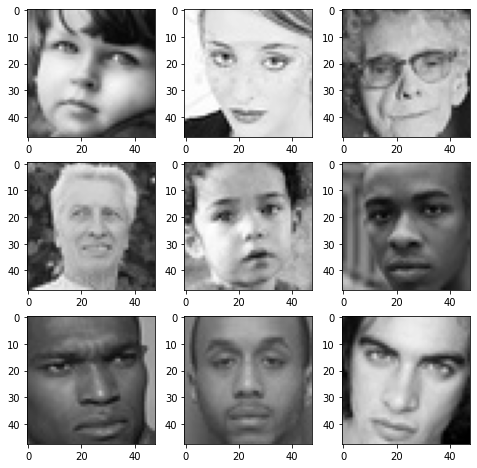

In [ ]:
# Show neutral images
show_images('neutral')

**Observations:**


*   Mouth often closed.
*   Eyes not shut or widely open.
*   Eyebrows usually relaxed in a gentle arc.
*   Person often looking at camera.



#### **Surprised**

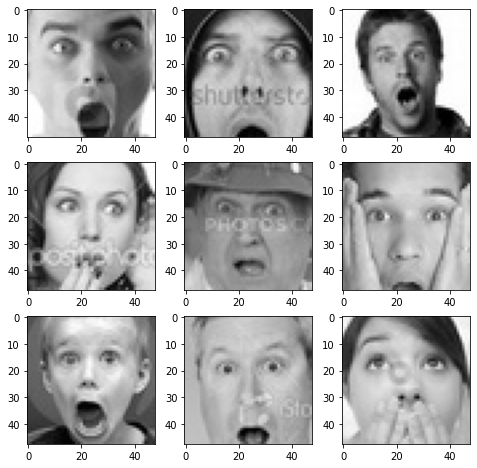

In [ ]:
# Show surprised images
show_images('surprise')

**Observations:**


*   Eyes open wide.
*   Mouth sometimes wide open, but not showing many teeth.
*   Eyebrows raised.
*   Lines often on forehead.



### **Checking Distribution of Classes**

Image counts for train set: 
Number of images in the class happy :    3976
Number of images in the class sad :    3982
Number of images in the class neutral :    3978
Number of images in the class surprise :    3173


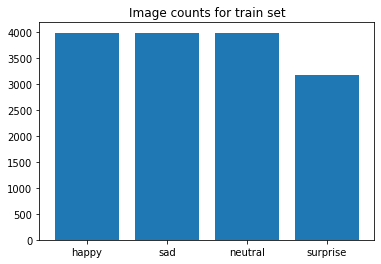

In [5]:
# Create a function to count the number of images in a set (train, val, test)
# and plot a histogram

def count_images(set = "train", emotions = ["happy", "sad", "neutral", "surprise"]):
  image_counts = []
  print("Image counts for " + set + " set: ")
  for emo in emotions:
    emo_count = len(os.listdir(folder_path + set + "/" + emo))
    image_counts.append(emo_count)
    print("Number of images in the class", emo, ":   ", emo_count)
  plt.bar(range(len(image_counts)), image_counts, tick_label = emotions)
  plt.title("Image counts for " + set + " set")

count_images()

Image counts for validation set: 
Number of images in the class happy :    1825
Number of images in the class sad :    1139
Number of images in the class neutral :    1216
Number of images in the class surprise :    797


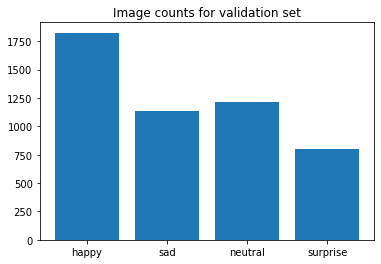

In [ ]:
# Show image counts for validation set
count_images(set = "validation")

Image counts for test set: 
Number of images in the class happy :    32
Number of images in the class sad :    32
Number of images in the class neutral :    32
Number of images in the class surprise :    32


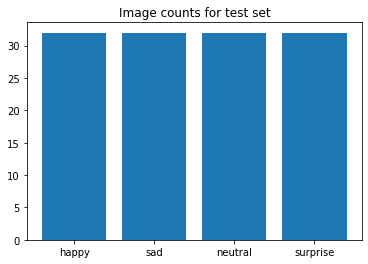

In [ ]:
# Show image counts for test set
count_images(set = "test")

**Observations:**


*   There are about 20% fewer examples of Surprise in the training set.
*   In the validation set, there are 40% more Happy and 30% fewer Surprise, compared to Sad and Neutral.
*   The test set is evenly distributed.



**Thoughts on dataset distributions:**<br>

The classes are not perfectly balanced, but I do not believe the numbers are so skewed that it will create a problem for the model.  One of the things we should check though is whether the model often misclassifies Surprised as one of the other three emotions based on an incorrect estimation of its prior probability (they are all equally likely in the test set).  My intuition is that it will not, since I believe surprise should be relatively easy to distinguish from the other three.

## **Part 2: CNN Model Building**

### **Why use convolutional neural networks (CNNs)?**

I believe CNNs are the right approach for this problem because they are able to detect local structures in an image - things like lines, edges, and curves.  These are the things we humans also use to read someone's emotion from their face - e.g., the edges of their mouth and the lines on their forehead.

The extensive feature detection and selection (e.g. through convolution and pooling) that occurs in a CNN prior to the classification step makes the classification a much easier problem.

Multilayer perceptrons (MLPs), on the other hand, have no awareness of local structure in an image because the raw image is converted directly into a 1D vector as the input.  If the image of a face is shifted ever so slightly in the input picture, the MLP would recieve a completely different input vector, which would make learning key features more difficult.

### **Create data loaders**

This section creates data loaders that will provide input data to our neural network models.

In [30]:
# Create a function to make the flow-from-directory data streams for each set.

def make_dataflow(folder_path, set_name, img_size = 48, color_mode = 'grayscale',
                  batch_size = 32, class_mode = 'categorical',
                  classes = ['happy', 'sad', 'neutral', 'surprise'],
                  preprocessing_function = None,
                  shuffle = True):
  generator = ImageDataGenerator(horizontal_flip = True,
                                 rotation_range=30,
                                 brightness_range = (0., 2.),
                                 rescale = 1./255,
                                 shear_range = 0.3,
                                 zoom_range=0.2,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 fill_mode='reflect',
                                 )
  return generator.flow_from_directory(folder_path + set_name,
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode,
                                              batch_size = batch_size,
                                              class_mode = class_mode,
                                              classes = classes,
                                              shuffle = shuffle)

In [31]:
# Create data loaders for each set

train_set = make_dataflow(folder_path, "train", color_mode = 'grayscale', batch_size = 24)
validation_set = make_dataflow(folder_path, "validation", color_mode = 'grayscale', batch_size = 24)
test_set = make_dataflow(folder_path, "test", color_mode = 'grayscale', batch_size = 128, shuffle = False)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model 1: Simple CNN**

Our starting model will have a fairly simple architecture:

* 3 convolutional blocks.
* Each convolutional block will have one Conv2D layer followed by a maxpooling layer and one Dropout layer.
* The model will use relu activation throughout (except for the output layer).
* The first Conv2D layer will have 64 filters, the other two will have 32.
* The model will have a single hidden dense layer with 512 neurons followed by the output layer (4 neurons with softmax activation).


In [7]:
# First, create a function to set the random seed and clear the backend
def reset_backend(seed = 1):
  # Set random seeds
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(1)

  # Clear backend
  backend.clear_session()

# Reset seed and clear backend
reset_backend()

In [21]:
# Initialize sequential model
model1 = Sequential()

# Add the first convolutional block
model1.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', input_shape = (48, 48, 1)))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))

# Add the second convolutional block
model1.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size = 2)) # or should it be (pool_size = (2, 2)))
model1.add(Dropout(0.2))

# Add the third convolutional block
model1.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size = 2)) # or should it be (pool_size = (2, 2)))
model1.add(Dropout(0.2))

# Add the flatten layer
model1.add(Flatten())

# Add dense layer
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.4))

# Add the output layer
model1.add(Dense(4, activation = 'softmax'))

# Print model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

#### **Compile and train model 1**

In [22]:
# Create callbacks list

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Set epochs
# epochs = 20 # Run 1
epochs = 30 # Run 2

In [23]:
# Compile model
model1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Fit model1
history_m1 = model1.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks =  callbacks_list)

Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.3380 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.44746, saving model to ./model1.h5
473/473 [==============================] - 23s 43ms/step - loss: 1.3380 - accuracy: 0.3333 - val_loss: 1.2218 - val_accuracy: 0.4475 - lr: 0.0010
Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 1.2194 - accuracy: 0.4501
Epoch 2: val_accuracy improved from 0.44746 to 0.49668, saving model to ./model1.h5
473/473 [==============================] - 21s 45ms/step - loss: 1.2195 - accuracy: 0.4499 - val_loss: 1.1496 - val_accuracy: 0.4967 - lr: 0.0010
Epoch 3/30
472/473 [============================>.] - ETA: 0s - loss: 1.1488 - accuracy: 0.4887
Epoch 3: val_accuracy improved from 0.49668 to 0.55355, saving model to ./model1.h5
473/473 [==============================] - 21s 45ms/step - loss: 1.1487 - accuracy: 0.4889 - val_loss: 1.0496 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 4/30
473/473 [=====

In [25]:
# Create a function to generate a plot of accuracy during training
def plot_training_acc(history):
  dict_hist = history.history
  list_ep = [i+1 for i in history.epoch] # The number of epochs varies, so get the list from history
  plt.figure(figsize = (8, 8))
  plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
  plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

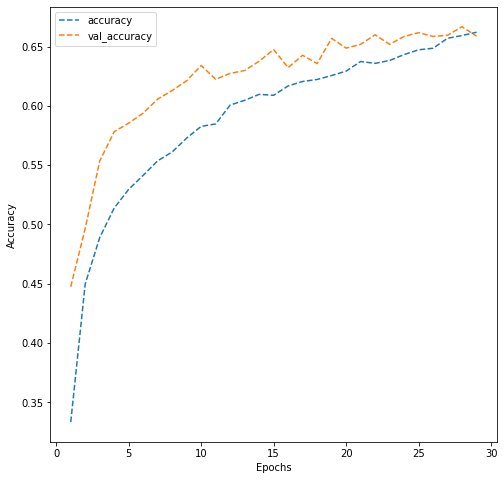

In [26]:
# Plot training accuracy for Model 1
plot_training_acc(history_m1)

#### **Model 1 training**
In the first run, accuracy on the training set reached a maximum of 65% by epoch 20, which was the maximum number of training epochs.  Accuracy on the validation set was slightly higher than that, and both accuracies appeard to still be increasing, so training for more epochs might have produced better results.  To test this, I increased the maximum epochs to 30 and trained the model again.

In the second run, accuracy on the test and validation sets peaked around 67%.  Training halted early at epoch 29 following a reduction in the learning rate that failed to decrease validation loss.

#### **Evaluate model 1 using the test set**

In [27]:
# Create a function to run the model on the test set then
# print a classification report and confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate_model(model, folder_path, data_set = "test", img_size = 48,
                   color_mode = 'grayscale',
                   emotions = ['happy', 'sad', 'neutral', 'surprise']
                   ):
  # Clear backend
  reset_backend()
  
  # Create data loader
  dg = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

  data_set = dg.flow_from_directory(folder_path + data_set,
                                    target_size = (img_size,img_size),
                                    color_mode =  color_mode,
                                    batch_size = 128,
                                    class_mode = 'categorical',
                                    classes = emotions,
                                    shuffle = False)
  
  data_images, data_labels = next(data_set)

  # Get predicted classes and true classes
  pred = model.predict(data_images)
  pred = np.argmax(pred, axis = 1) 
  y_true = np.argmax(data_labels, axis = 1)

  # Print the classification report
  print(classification_report(y_true, pred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_true, pred)
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f', 
              xticklabels = emotions, 
              yticklabels = emotions)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.62      0.75      0.68        32
           1       0.27      0.34      0.30        32
           2       0.28      0.22      0.25        32
           3       0.96      0.69      0.80        32

    accuracy                           0.50       128
   macro avg       0.53      0.50      0.51       128
weighted avg       0.53      0.50      0.51       128



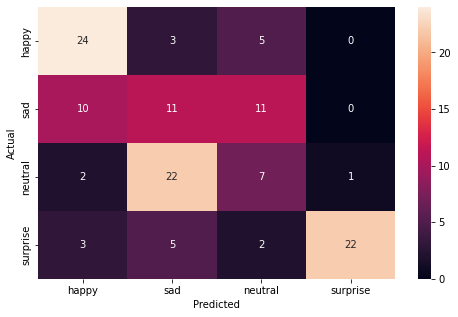

In [28]:
# Evaluate model 1
evaluate_model(model1, folder_path, color_mode = 'grayscale')

**Observations:**

Model 1 had a very tough time distinguishing Neutral from Sad (and vice versa).  It performed best on Surprise (despite it being under-represented in the training set).  As mentioned above a surprised person has a number of distinctive features, so I am not surprised that the model did well with that category.  Conversely, it can be difficult even for humans to distinguish between a sad and a neutral person, so it is also not surprising that the model often confused those two classes.

### **Model 2: Intermediate CNN**

In the second CNN model, we will add another convolutional block and add batch normalization layers.

* Each Convolutional block will have 1 Conv2D layer, followed by a BatchNormalization, LeakuRelU activation, and a MaxPooling2D layer.
* The model will not have dropout layers this time.
* The first Conv2D layer will have 256 filters and that number will be cut in half in each subsequent Conv2D layer.
* The model will have two dense layers, the first with 512 neurons and the second with 128.
* The output layer will have 4 neurons with softmax activation like Model 1.


In [8]:
# Clear backend
reset_backend()

In [10]:
# Create sequential model
model2 = Sequential()
 
# Add the first Convolutional block
model2.add(Conv2D(filters = 256, kernel_size = 2, padding = 'same', input_shape = (48, 48, 1), activation = 'relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))

# Add the second Convolutional block
model2.add(Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))

# Add the third Convolutional block
model2.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))

# Add the fourth Convolutional block
model2.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size = 2))

# Add the Flatten layer
model2.add(Flatten())

# Adding the Dense layers
model2.add(Dense(512, activation='relu'))
model2.add(Dense(128, activation='relu'))

# Add the output layer
model2.add(Dense(4, activation = 'softmax'))

# Print model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 256)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

#### **Compile and train model 2**

In [11]:
# Create callbacks list

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

# Set maximum epochs
# epochs = 20 # Run 1
epochs = 10


In [12]:
# Compile model2
model2.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Fit model 2
history_m2 = model2.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)

Epoch 1/10
473/473 [==============================] - ETA: 0s - loss: 1.2688 - accuracy: 0.3995
Epoch 1: val_accuracy improved from -inf to 0.43018, saving model to ./model2.h5
473/473 [==============================] - 38s 49ms/step - loss: 1.2688 - accuracy: 0.3995 - val_loss: 1.3257 - val_accuracy: 0.4302 - lr: 0.0010
Epoch 2/10
473/473 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.5318
Epoch 2: val_accuracy improved from 0.43018 to 0.56821, saving model to ./model2.h5
473/473 [==============================] - 23s 49ms/step - loss: 1.0589 - accuracy: 0.5318 - val_loss: 1.0414 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 3/10
473/473 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.5906
Epoch 3: val_accuracy improved from 0.56821 to 0.59614, saving model to ./model2.h5
473/473 [==============================] - 23s 49ms/step - loss: 0.9515 - accuracy: 0.5906 - val_loss: 0.9594 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 4/10
473/473 [=====

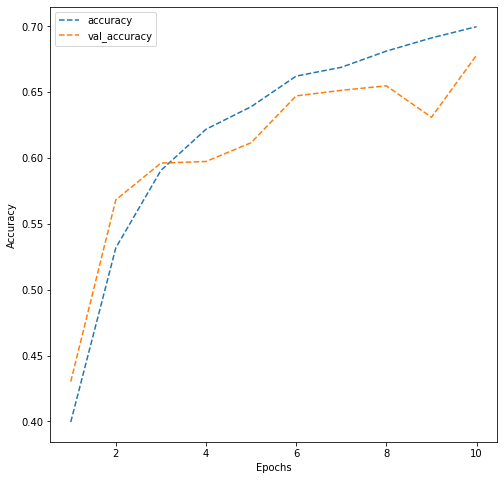

In [17]:
# Plot training accuracy for Model 2
plot_training_acc(history_m2)

#### **Training of model 2: Observations**
Run 1: Accuracy on the training set reached a maximum of around 68% by epoch 10 and did not improve very much beyond that;  accuracy on the training set continued to improve indicating the model was likely over-fitting the training data.  Accuracy on the test set was only 54%.

Run 2: I halted training at epoch 10 to avoid over-fitting.

#### **Evaluate model 2 using the test set**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.61      0.72      0.66        32
           1       0.24      0.25      0.25        32
           2       0.25      0.19      0.21        32
           3       0.79      0.81      0.80        32

    accuracy                           0.49       128
   macro avg       0.47      0.49      0.48       128
weighted avg       0.47      0.49      0.48       128



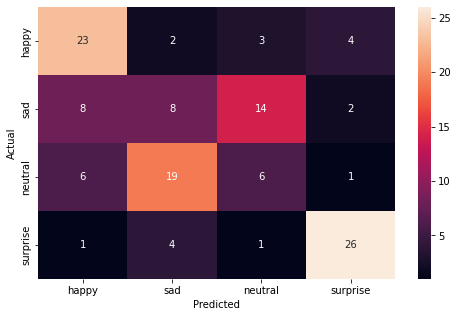

In [29]:
# Evaluate model 2
evaluate_model(model2, folder_path, color_mode = 'grayscale')

**Observations and Insights:**

Model 2 performed roughly the same as model 1; the changes made to the architecture did not significantly impact performance.

### **Model 3: Complex CNN**

This model is more complex than the previous models and contains many more trainable parameters.

#### **Build the model**

* This model will have 5 Convolutional Blocks
* Both the convolutional and classification sections will contain dropout layers
* The classification layers will have more neurons than models 1 and 2
* The model will undergo more optimization attempts than either model 1 or 2

In [ ]:
# Reset seed and clear backend
if model3: del model3
reset_backend()

In [ ]:
no_of_classes = 4

model3 = Sequential()

# Add 1st CNN Block
model3.add(Conv2D(filters = 96, kernel_size = 4, padding = 'same', 
                  input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 2nd CNN Block
model3.add(Conv2D(filters = 192, kernel_size = 4, padding = 'same', 
                  input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 3rd CNN Block
model3.add(Conv2D(filters = 768, kernel_size = 4, padding = 'same', 
                  input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 4th CNN Block
model3.add(Conv2D(filters = 512, kernel_size = 4, padding = 'same', 
                  input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add 5th CNN Block
model3.add(Conv2D(filters = 192, kernel_size = 4, padding = 'same', 
                  input_shape = (48, 48, 1), activation = 'relu'))
model3.add(BatchNormalization())
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size = 2))
model3.add(Dropout(0.2))

# Add flattening layer
model3.add(Flatten())

# First fully connected layer
model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(Dropout(0.2))

# Second fully connected layer
model3.add(Dense(512))
model3.add(BatchNormalization())
model3.add(ReLU())
model3.add(Dropout(0.2))

# Add output layer
model3.add(Dense(no_of_classes, activation = 'softmax'))

In [ ]:
# Print model summary
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 96)        1632      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 96)       384       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 192)       2

#### **Compile and train model 3**

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

epochs = 50

steps_per_epoch = train_set.n//train_set.batch_size
validation_steps = validation_set.n//validation_set.batch_size

checkpoint = ModelCheckpoint("model3.h5", monitor = 'val_accuracy',
                            save_weights_only = True, model = 'max', verbose = 1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 3, min_lr = 0.00001 , model = 'auto')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True
                          )

callbacks = [checkpoint, reduce_lr]

In [ ]:
# Compile model
model3.compile(optimizer=Adam(0.0002), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
# Fit model
history_m3 = model3.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks)


Epoch 1/50
630/630 [==============================] - ETA: 0s - loss: 1.5566 - accuracy: 0.2659
Epoch 1: saving model to model3.h5
630/630 [==============================] - 45s 56ms/step - loss: 1.5566 - accuracy: 0.2659 - val_loss: 1.3403 - val_accuracy: 0.3647 - lr: 2.0000e-04
Epoch 2/50
630/630 [==============================] - ETA: 0s - loss: 1.4857 - accuracy: 0.2757
Epoch 2: saving model to model3.h5
630/630 [==============================] - 34s 54ms/step - loss: 1.4857 - accuracy: 0.2757 - val_loss: 1.3551 - val_accuracy: 0.3171 - lr: 2.0000e-04
Epoch 3/50
630/630 [==============================] - ETA: 0s - loss: 1.4214 - accuracy: 0.3084
Epoch 3: saving model to model3.h5
630/630 [==============================] - 34s 54ms/step - loss: 1.4214 - accuracy: 0.3084 - val_loss: 1.3336 - val_accuracy: 0.3528 - lr: 2.0000e-04
Epoch 4/50
630/630 [==============================] - ETA: 0s - loss: 1.3539 - accuracy: 0.3354
Epoch 4: saving model to model3.h5
630/630 [=================

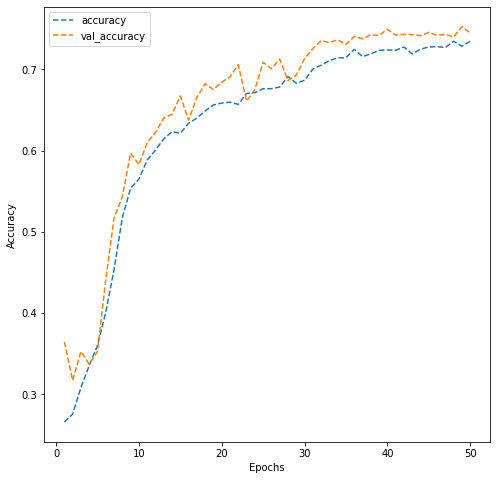

In [ ]:
# Examine accuracy of model 3 during training
plot_training_acc(history_m3)

> **Observations**

> Both the training set and validation set accuracies plateaued around 73%.  There was very little divergence between them.  This is just about the ideal situation; there's no sign of over-fitting (because the curves don't diverge) or under-fitting (because they plateau by the end of training).

#### **Evaluate model 3 on the test set**

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1825
           1       0.64      0.63      0.64      1139
           2       0.64      0.66      0.65      1216
           3       0.78      0.85      0.81       797

    accuracy                           0.74      4977
   macro avg       0.73      0.74      0.73      4977
weighted avg       0.74      0.74      0.74      4977



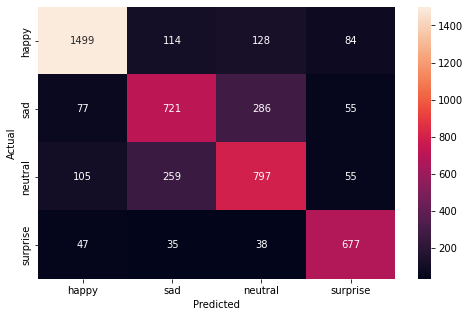

In [ ]:
# Test the model, then print classification report and confusion matrix
evaluate_model(model3, folder_path, set_name = "validation", batch_size = 4977, img_size = 48,
                     color_mode = 'grayscale')

**Observations:**

This was the best performing model so far.  It had the toughest time distinguishing sad faces from neutral ones.  This is to be expected because the differences between those two expressions can be very subtle.

Training the model using a GPU runtime on Google Colab took about 10 minutes, which is a manageable timeframe for testing adjustments to the model's hyper parameters.

#### **Further optimization of model 3**

The following list shows additional changes that I attempted to improve the model's performance.  During this optimization process, I tested the model on the validation set.  Testing on the test set and then making adjustments that improved performance could bias the model toward that set.  Since the test set is relatively small (128 images), the risk of doing that is significant.

The percentage after each change is the model's accuracy on the validation set after making the change.  Changes that decreased the model's performance were discarded unless otherwise noted.

*   Initial accuracy: 71%
*   Increased kernal sizes to 3: 72%
*   Increased kernal sizes to 4: 73%
*   Decreased learing rate to 0.001: 73%
*   Added early stopping (to speed optimazation) and added rotation_range=30: 73%
*   Added the below: 72%

> zoom_range=0.2<br>
> width_shift_range=0.1<br>
> height_shift_range=0.1<br>
> fill_mode='reflect'<br>

*   Increased batch size to 64: 71% but still increasing
*   Decreased batch size to 24: 72%, still increasing
*   Increased filters by 50%: 73%
*   Decreased learning rate to 0.0005: 73%
*   Decreased learning rate to 0.0002, decreased min_lr to 0.00001, increased learning patience to 3: 73%
*   Increased learning rate to 0.001, but kept min_lr at 0.00001 learning rate patience at 3, increased stopping patience to 7: 72%
*   Reverting to best model (73% accuracy), but removing early stopping, running for 50 epochs: 74% (final model)

**Observations:** I was only able to improve accuracy by a few percentage points in the second round of model optimization.  Increasing the kernal size to 4 (from 2), and letting the model learn for 50 epochs each seemed beneficial.

Perfomance of the model on the test set (shown below) only increased from a 76% accuracy to 77%.  This is the best perfoming model I tested (including those below).  It does very well at distinguishing Happy and Surprised (86%, 90%), but is less able to distinguish Sad and Neutral (68%, 67%).  Since Sad and Neutral are mainly confused with each other, the model would be ideal for a use case in which distinguishing between Sad and Neutral was not important.

#### **Evaluating the performance of the optimized model 3 on the test set**

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.70      0.66      0.68        32
           2       0.62      0.72      0.67        32
           3       0.93      0.88      0.90        32

    accuracy                           0.77       128
   macro avg       0.78      0.77      0.78       128
weighted avg       0.78      0.77      0.78       128



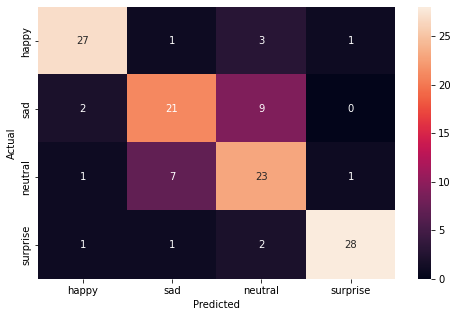

In [ ]:
# Reprint the results for the final chosen model (model 3)
evaluate_model(model3, folder_path, set_name = "test", img_size = 48,
                     color_mode = 'grayscale')

We have built two Convolutional Neural Network architectures in Milestone 1. Here, we will further try to achieve better performance by increasing the number of parameters/weights. Therefore, we will start this Milestone with three popular Transfer Learning architectures, namely, VGG16, ResNet v2, and Efficient Net. Please feel free to explore other pre-trained models as well. Link to Keras documentation for pre-trained models - https://keras.io/api/applications/

**Note:** We will mount our drive and import our dataset once again for Milestone 2.

## **Part 3: Transfer Learning Models**

*Note: This part was originally a separate notebook; I have removed some redundancies with Part 2 but some remain.*

### **Import libraries**

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import cv2 

# Importing Deep Learning Libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad

#### **Creating data loaders for transfer learning architectures**

In [ ]:
# Create a function to make the flow-from-directory data streams for each set.
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16_pp

def make_dataflow(folder_path, set_name, img_size = 48, color_mode = 'rgb',
                  batch_size = 32, class_mode = 'categorical',
                  classes = ['happy', 'sad', 'neutral', 'surprise'],
                  shear_range = 0,
                  preprocessing_function = None,
                  shuffle = True):
  generator = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = shear_range,
                                    preprocessing_function = preprocessing_function)
  return generator.flow_from_directory(folder_path + set_name,
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode,
                                              batch_size = batch_size,
                                              class_mode = class_mode,
                                              classes = classes,
                                              shuffle = shuffle)

train_set = make_dataflow(folder_path, "train", shear_range = 0, preprocessing_function = VGG16_pp)
validation_set = make_dataflow(folder_path, "validation", shear_range = 0, preprocessing_function = VGG16_pp)
test_set = make_dataflow(folder_path, "test", batch_size = 128, preprocessing_function = VGG16_pp, shuffle = False)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


#### **Create a function to set the random seed and clear the backend**

In order to assess whether a particular change to a model helped or hurt, I reset the random seed to the same value before every run and clear the backend of (potential) residual parameters.  I also delete the old model (which isn't part of the below function) and rebuilt it from scratch each time, as failure to do so produced variation in the results (even when no parameters were changed).

In [ ]:
# Create a function to set the random seed and clear the backend
def reset_backend(seed = 1):
  import numpy as np
  import tensorflow as tf
  import random
  from tensorflow.keras import backend

  # Set random seeds
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(1)

  # Clear backend
  backend.clear_session()

### **VGG16 Model**

#### **Import the VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**

* In this model, we import untill the **'block3_pool'** layer of the VGG16 model.
* We then add a Flatten layer, which receives the output of the 'block5_pool' layer as its input.
* We then add a few dense layers and use 'relu' activation function on them.
* The output layer has 4 neurons and a 'softmax' activation function.

In [ ]:
if vggmodel: del vggmodel # Completely clear the old model (if there is one)
reset_backend()

In [ ]:
# Create VGG16 model

# Set transfer layer and fix VGG parameters
transfer_layer = vgg.get_layer('block3_pool')
vgg.trainable = False

# Flatten the output from the 3rd block of the VGG16 model
x = Flatten()(transfer_layer.output)

# Adding a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Adding the final dense layer with 4 neurons and use 'softmax' activation
pred = Dense(4, activation='softmax')(x)

vggmodel = Model(vgg.input, pred) # Initializing the model

#### **Compiling and Training the VGG16 Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./vggmodel.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 30

In [ ]:
# Compile model
vggmodel.compile(optimizer=RMSprop(0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print summary of the model
vggmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# Fit model
history_vgg1 = vggmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)

Epoch 1/30
473/473 [==============================] - ETA: 0s - loss: 1.1807 - accuracy: 0.4760
Epoch 1: val_accuracy improved from -inf to 0.61161, saving model to ./vggmodel.h5
473/473 [==============================] - 17s 33ms/step - loss: 1.1807 - accuracy: 0.4760 - val_loss: 0.9295 - val_accuracy: 0.6116 - lr: 0.0010
Epoch 2/30
472/473 [============================>.] - ETA: 0s - loss: 0.9455 - accuracy: 0.6001
Epoch 2: val_accuracy did not improve from 0.61161
473/473 [==============================] - 15s 31ms/step - loss: 0.9458 - accuracy: 0.6000 - val_loss: 0.9758 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/30
473/473 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.6235
Epoch 3: val_accuracy improved from 0.61161 to 0.64095, saving model to ./vggmodel.h5
473/473 [==============================] - 15s 31ms/step - loss: 0.8911 - accuracy: 0.6235 - val_loss: 0.8660 - val_accuracy: 0.6409 - lr: 0.0010
Epoch 4/30
471/473 [============================>.] - 

#### **Evaluate the VGG16 model**

In [ ]:
# Make a function to generate plot of accuracy during training
def plot_training_acc(history):
  dict_hist = history.history
  list_ep = [i+1 for i in history.epoch] # The number of epochs varies, so get the list from history
  plt.figure(figsize = (8, 8))
  plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
  plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()

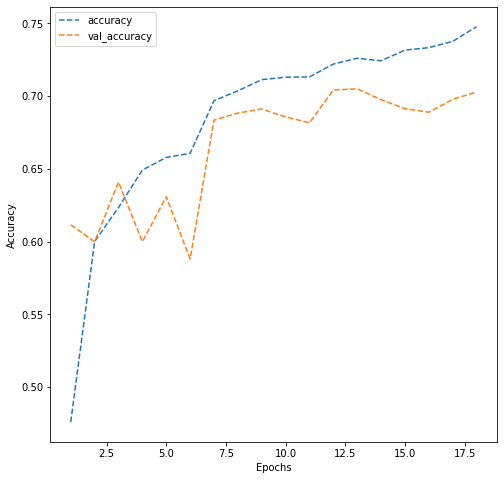

In [ ]:
# Call the training history plot function
plot_training_acc(history_vgg1)

In [ ]:
# The function below uses the input model to generate predictions for the test (or validation)
# set, then prints a classification report and confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def evaluate_model(model, folder_path, set_name = "test", batch_size = 128,
                   shear_range = 0,
                   preprocessing_function = None,
                   img_size = 48, color_mode = 'rgb'):
  
  data_set = make_dataflow(folder_path, set_name, color_mode = color_mode,
                           batch_size = batch_size,
                           preprocessing_function = preprocessing_function,
                           shuffle = False)
  
  data_images, data_labels = next(data_set)

  # Get predicted classes and true classes
  pred = model.predict(data_images)
  pred = np.argmax(pred, axis = 1) 
  y_true = np.argmax(data_labels, axis = 1)

  # Print the classification report
  print(classification_report(y_true, pred))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_true, pred)
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f', 
              xticklabels = ['happy', 'sad', 'neutral', 'surprise'], 
              yticklabels = ['happy', 'sad', 'neutral', 'surprise'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()


**Note:** After each adjustment to the model I tested performance on the validation set to avoid over-fitting the test set, which is only seen once by each model. 

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1825
           1       0.63      0.56      0.59      1139
           2       0.57      0.68      0.62      1216
           3       0.81      0.75      0.78       797

    accuracy                           0.70      4977
   macro avg       0.70      0.69      0.69      4977
weighted avg       0.71      0.70      0.70      4977



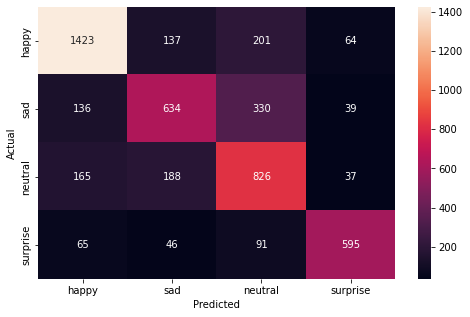

In [ ]:
# Call the above function to evaluate the model on the validation set
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16_pp

evaluate_model(vggmodel, folder_path, set_name = "validation", batch_size = 4977, 
               preprocessing_function = VGG16_pp, color_mode = 'rgb')

**Observations:**

The training accuracy generally improves throughout training.  This is not surprising, as models that are continually trained on their training sets will show improved performance as they learn idiosyncracies (false signals) in the data. 

Accuracy on the validation set was eratic at first, but by epoch 9 it appeared to plateau.  The maximum validation set accuracy was 70%, achieved at epoch 12.




#### **Further optimizing the VGG16 model**<br>
The following list shows changes that I attempted to improve the model's performance.  During this optimization process, I tested the model on the validation set.  Testing on the test set and then making adjustments that improved performance could bias the model toward that set.  Since the test set is relatively small (128 images), the risk of doing that is significant.

The percentage after each change is the model's accuracy on the validation set after making the change.  Changes that decreased the model's performance were discarded unless otherwise noted.

**Optimization Log:**

*   Initial accuracy: 52%
*   Added VGG16 preprocessing: 51% but less variation in validation set during training, so kept change
*   Reduced nodes in classification layers by 50%: 50%
*   Increased nodes in classification layers by 50%: 49%
*   Changed optimizer to RMSprop: 50% but it looked like a longer run would improve it, so kept change
*   Reduced learning rate to 0.0005; also increased patience for stopping training to 5 and epochs to 30 to prevent early stopping: 52%
*   Reduced sheer to 0.15: 51%
*   Transferred from end of block 4: 65%
*   Transferred from end of block 3: 69%
*   Transferred from end of block 2: 64%
*   Reduced sheer to 0.15: 69%
*   Reduced sheer to 0: 69%
*   Reduced learning rate to 0.0002: 68%
*   Increased learning rate to 0.001: 70%
*   Increased learning rate to 0.002: 67%

**Observations:**
By far the largest improvement was to use less of the VGG16 model; transferring the network after block 3 increased accuracy to 69%.  This could be due to the VGG16 model learning to differeniate between 1000 classes -- by blocks 4 and 5 of the model, each face we use as input may look very much the same to the VGG16 model.<br>
<br>
None of the other changes I tested had a large impact on model performance.  The best VGG16 model I tested transferred from block 3, used the RMSprop optimizer, reduced sheer to 0, used VGG16 preprocessing, used a learning rate of 0.001, and increased patience for stopping training to 5.

This model scored a 70% accuracy on the validation set, and
a 74% accuracy on the test set (see below).  The worst performing category was Sad, with a 61% F1 score, followed by Neutral with 76%.

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.74      0.81      0.78        32
           1       0.71      0.53      0.61        32
           2       0.67      0.88      0.76        32
           3       0.89      0.75      0.81        32

    accuracy                           0.74       128
   macro avg       0.75      0.74      0.74       128
weighted avg       0.75      0.74      0.74       128



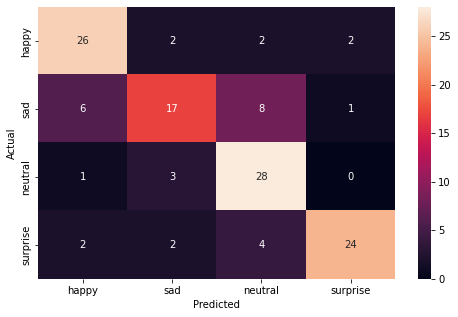

In [ ]:
# Test final optimized model on the test set
evaluate_model(vggmodel, folder_path, set_name = "test", batch_size = 128, 
               preprocessing_function = VGG16_pp, color_mode = 'rgb')

## **ResNet V2 Model**

In [ ]:
# Reset seed and clear backend (this function is defined above)
reset_backend()

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 8s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                       

### **Model Building**

* In this model, we will import (initially) untill the **'conv5_block3_add'** layer of the ResNet model.
* Then we will add a Flatten layer, which receives the output of the 'conv5_block3_add' layer as its input.
* We will add a few Dense layers and use 'relu' activation function on them.
* The last layer will have 4 neurons and a 'softmax' activation function, as usual.

In [ ]:
if resnetmodel: del resnetmodel # Completely clear the old model (if there is one)

In [ ]:
# Original transfer layer
# transfer_layer_Resnet = Resnet.get_layer('conv5_block3_add')

# Using less of the Resnet model:
transfer_layer_Resnet = Resnet.get_layer('conv3_block3_add')

Resnet.trainable=False

# Add classification layers on top of it

# Flatten the output from the ResNet model
x = Flatten()(transfer_layer_Resnet.output)

# Add a Dense layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

## Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 32 neurons
x = Dense(32, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

resnetmodel = Model(Resnet.input, pred) # Initializing the model

resnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

#### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Resnetmodel.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 20


In [ ]:
reset_backend()
resnetmodel.compile(optimizer=RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
# Modify dataset preprocessing
from tensorflow.keras.applications.resnet import preprocess_input as ResNet_pp

train_set = make_dataflow(folder_path, "train", batch_size = 64, preprocessing_function = ResNet_pp)
validation_set = make_dataflow(folder_path, "validation", batch_size = 64, preprocessing_function = ResNet_pp)
test_set = make_dataflow(folder_path, "test", batch_size = 128, 
                          preprocessing_function = ResNet_pp, shuffle = False)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [ ]:
# Fit model
history_resnet = resnetmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)


Epoch 1/20
237/237 [==============================] - ETA: 0s - loss: 1.3344 - accuracy: 0.4202
Epoch 1: val_accuracy improved from -inf to 0.27245, saving model to ./Resnetmodel.h5
237/237 [==============================] - 18s 67ms/step - loss: 1.3344 - accuracy: 0.4202 - val_loss: 4.0787 - val_accuracy: 0.2725 - lr: 1.0000e-04
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 1.1846 - accuracy: 0.4835
Epoch 2: val_accuracy improved from 0.27245 to 0.28431, saving model to ./Resnetmodel.h5
237/237 [==============================] - 14s 61ms/step - loss: 1.1846 - accuracy: 0.4835 - val_loss: 3.0536 - val_accuracy: 0.2843 - lr: 1.0000e-04
Epoch 3/20
236/237 [============================>.] - ETA: 0s - loss: 1.1211 - accuracy: 0.5176
Epoch 3: val_accuracy improved from 0.28431 to 0.37071, saving model to ./Resnetmodel.h5
237/237 [==============================] - 17s 71ms/step - loss: 1.1211 - accuracy: 0.5177 - val_loss: 1.8136 - val_accuracy: 0.3707 - lr: 1.0000e-0

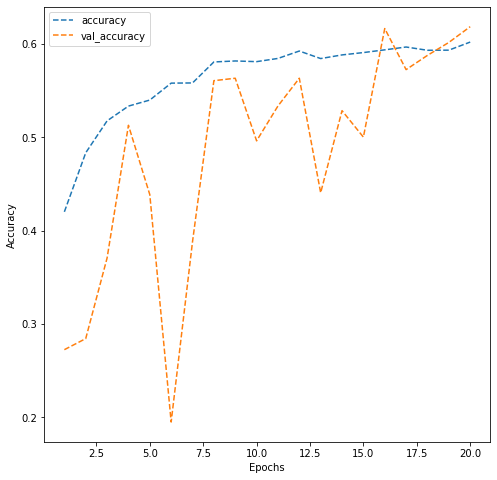

In [ ]:
# Examine accuracy during training
plot_training_acc(history_resnet)

### **Evaluating the ResNet Model**

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      1825
           1       0.49      0.47      0.48      1139
           2       0.57      0.50      0.53      1216
           3       0.64      0.72      0.68       797

    accuracy                           0.61      4977
   macro avg       0.60      0.60      0.60      4977
weighted avg       0.61      0.61      0.61      4977



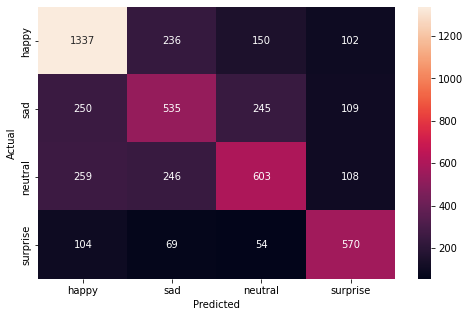

In [ ]:
# Run ResNet model on validation set and show results
from tensorflow.keras.applications.resnet import preprocess_input as ResNet_pp

evaluate_model(resnetmodel, folder_path, set_name = "validation", batch_size = 4977, img_size = 48,
               preprocessing_function = ResNet_pp, color_mode = 'rgb')

#### **Further optimizing the ResNet model**<br>

The following list shows additional changes that I attempted to improve the model's performance.  During this optimization process, I tested the model on the validation set.  Testing on the test set and then making adjustments that improved performance could bias the model toward that set.  Since the test set is relatively small (128 images), the risk of doing that is significant.

The percentage after each change is the model's accuracy on the validation set after making the change.  Changes that decreased the model's performance were discarded unless otherwise noted.

**Optimization Log:**

*   Initial accuracy: 25%
*   Added ResNet preprocessing: 37%
*   Transferred network at conv2_block1_add: 37%
*   Transferred network at conv3_block1_add: 37%
*   Reduced nodes in classification network by 50%: 24%
*   Added two BatchNormalization layers: 37%
*   Reduced learning rate to 0.0005: 34%, but not all same class, so kept change
*   Doubled batch size from 32 to 64: 41%
*   Doubled batch size from 64 to 128: 39%
*   Expanded to block5 and reduced learning rate to 0.0001: 33%
*   Reduced to conv3_block3_add: 44%
*   Increased stop patience to 5 and epochs to 30: 61%
*   Added two new Dropout layers: 56%
*   Reduced nodes in classification network by 50%: 61%
*   Transferred network at conv2_block3_add: 60%
*   Transferred network at conv4_block3_add: 41%
*   Increased epochs to 40: 60%
*   Reduced epochs to 20: 61%

**Observations:**

The first test of the ResNet model was a failure: it classified every image as Happy.  A plot of training accuracy showed non-improvement of accuracy on the training set and wildly fluctuating performance on the validation set.

After testing various changes, I finally started to see improvement when I reduced the learning rate.  Reducing the transfer layer to convolutional block 3 and increasing the batch size to 64 also helped a lot.  I did not see much impact when I made changes to the model's architecture.

The best model achieved an accuracy of 61% on the validation set and 60% on the training set (see below).  Its worst category was Sad, with an F1 score of 45%, followed by neutral with 53%.

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.56      0.75      0.64        32
           1       0.50      0.41      0.45        32
           2       0.53      0.53      0.53        32
           3       0.85      0.72      0.78        32

    accuracy                           0.60       128
   macro avg       0.61      0.60      0.60       128
weighted avg       0.61      0.60      0.60       128



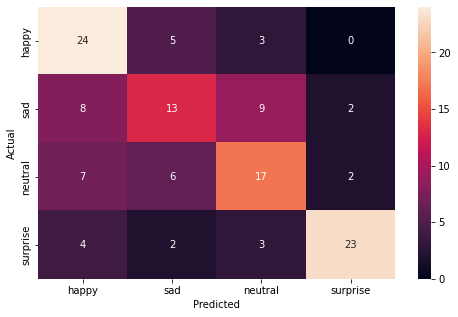

In [ ]:
# Run best model on test set
evaluate_model(resnetmodel, folder_path, data_set = "test", batch_size = 128, img_size = 48,
                     color_mode = 'rgb')

### **EfficientNet Model**

In [ ]:
# Reset seed and clear backend
reset_backend()

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
EfficientNet = ap.EfficientNetV2B2(include_top=False,weights="imagenet", input_shape= (48, 48, 3))

EfficientNet.summary()

35839040/35839040 [==============================] - 2s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                 

### **Model building**

In [ ]:
if Efficientnetmodel: del Efficientnetmodel # Completely clear the old model (if there is one)
reset_backend()

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling2D

# Using less of the EfficientNet model
# transfer_layer_EfficientNet = EfficientNet.get_layer('block6e_expand_activation')
transfer_layer_EfficientNet = EfficientNet.get_layer('block4c_add')

EfficientNet.trainable = False

# Using a global max pooling layer instead of flatten
# x = Flatten()(transfer_layer_EfficientNet.output)
x = GlobalMaxPooling2D()(transfer_layer_EfficientNet.output)

# Add your Dense layers and/or BatchNormalization and Dropout layers

# Add a Dense Layer with 512 neurons
x = Dense(128, activation = 'sigmoid')(x)

x = BatchNormalization()(x)

# Add a Dense Layer with 256 neurons
x = Dense(256, activation = 'sigmoid')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'sigmoid')(x)

# Add a BatchNormalization layer
x = BatchNormalization()(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'sigmoid')(x)

# Add final Dense layer with 4 neurons and softmax activation function.
pred = Dense(4, activation = 'softmax')(x)

Efficientnetmodel = Model(EfficientNet.input, pred)

Efficientnetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 48, 48, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 48, 48, 3)    0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 24, 24, 32)   864         ['normalization[0][0]']          
                                                                                              

### **Compiling and Training the Model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Efficientnetmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True
                          )  # Write your code here. You may play around with the hyperparameters if you wish.

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)  # Write your code here. You may play around with the hyperparameters if you wish.

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 25


In [ ]:
# Compile model
Efficientnetmodel.compile(optimizer=RMSprop(0.0003), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
# Modify dataset preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as EffNet_pp

train_set = make_dataflow(folder_path, "train", batch_size = 128, shear_range = 0.3, 
                          preprocessing_function = EffNet_pp)
validation_set = make_dataflow(folder_path, "validation", batch_size = 128,
                               preprocessing_function = EffNet_pp)
test_set = make_dataflow(folder_path, "test", batch_size = 128,
                          preprocessing_function = EffNet_pp, shuffle = False)


Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [ ]:
# Fit model
history_eff = Efficientnetmodel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)


Epoch 1/25
119/119 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.3188
Epoch 1: val_accuracy improved from -inf to 0.22885, saving model to ./Efficientnetmodel.h5
119/119 [==============================] - 30s 230ms/step - loss: 1.3576 - accuracy: 0.3188 - val_loss: 1.4069 - val_accuracy: 0.2289 - lr: 3.0000e-04
Epoch 2/25
119/119 [==============================] - ETA: 0s - loss: 1.3091 - accuracy: 0.3646
Epoch 2: val_accuracy did not improve from 0.22885
119/119 [==============================] - 36s 299ms/step - loss: 1.3091 - accuracy: 0.3646 - val_loss: 1.3833 - val_accuracy: 0.2289 - lr: 3.0000e-04
Epoch 3/25
119/119 [==============================] - ETA: 0s - loss: 1.2907 - accuracy: 0.3781
Epoch 3: val_accuracy improved from 0.22885 to 0.25980, saving model to ./Efficientnetmodel.h5
119/119 [==============================] - 31s 258ms/step - loss: 1.2907 - accuracy: 0.3781 - val_loss: 1.3787 - val_accuracy: 0.2598 - lr: 3.0000e-04
Epoch 4/25
119/119 [=

### **Evaluating the EfficientnetNet Model**

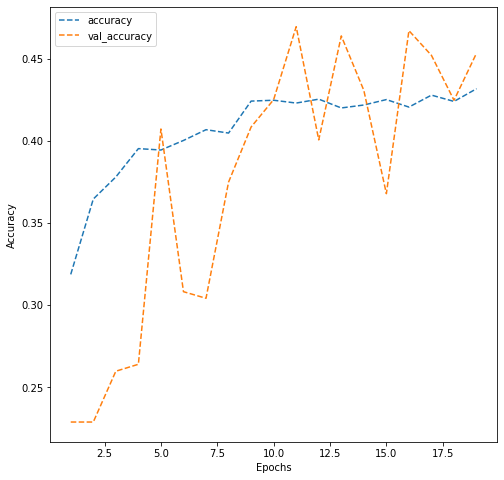

In [ ]:
# Examine accuracy during training
plot_training_acc(history_eff) # This function is defined above

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.45      0.83      0.58      1825
           1       0.40      0.24      0.30      1139
           2       0.46      0.15      0.22      1216
           3       0.59      0.39      0.47       797

    accuracy                           0.46      4977
   macro avg       0.47      0.40      0.39      4977
weighted avg       0.46      0.46      0.41      4977



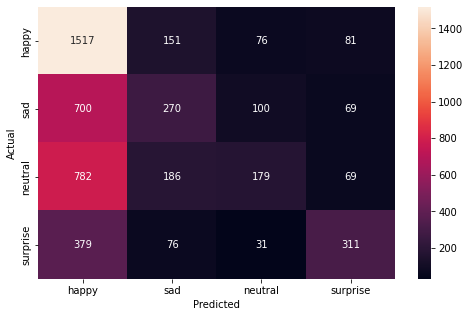

In [ ]:
# Run ResNet model on validation set and show results
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as EffNet_pp

evaluate_model(Efficientnetmodel, folder_path, set_name = "validation", batch_size = 4977, img_size = 48,
               preprocessing_function = EffNet_pp, color_mode = 'rgb')

**Observations:**

My initial attempt was similar to the results from the ResNet model - it classified all images as Happy.  Since, compared to ResNet and EfficientNet, I had some success with the VGG16 model I decided to copy that architecture exactly and apply it to EfficientNet.  This architecture failed to successfully classify the images as well.

#### **Further optimizing the EfficientNet model**<br>

The following list shows additional changes (made after submitting the original version of this notebook) that I attempted to improve the model's performance.  During this optimization process, I tested the model on the validation set.  Testing on the test set and then making adjustments that improved performance could bias the model toward that set.  Since the test set is relatively small (128 images), the risk of doing that is significant.

The percentage after each change is the model's accuracy on the validation set after making the change.  Changes that decreased the model's performance were discarded unless otherwise noted.

**Optimization Log:**

*   Initial accuracy: 25%
*   Added EfficientNet preprocessing: 25%
*   Moved transfer layer to block3c_add: 25%
*   Reduced learning rate to 0.0001: 25%
*   Doubled batch size to 64: 25%
*   Doubled batch size to 128: 35%
*   Reduced learning rate to 0.00005, increased stopping patience to 5: 32%
*   Reduced number of nodes in classification layers by 50%: 35%
*   Changed flatten layer to global max pooling: 37%
*   Moved transfer layer to block4c_add, changed optimizer to RMSprop, increased stopping patience to 4: 36%
*   Doubled nodes in classification layers: 16%
*   Simplified classification network (removed BatchNormalization and Dropout layers): 32% (but not all in one class)
*   Modified classification network: 4 dense layers (128, 256, 128, 64): 31%
*   Added two BatchNormalization layers: 43%
*   Moved transfer layer to block5f_add: 36% (but looks like it stopped too early)
*   As above but increased stopping patience to 6: 40%
*   Moved transfer layer to block3c_add: 40%
*   Lowered learning rate to 0.0005: 43%
*   Added a dropout layer: 37%
*   Added a BatchNormalization layer: 36%
*   Changed activation functions to tanh: 44%
*   Changed activatoin functions to sigmoid: 46%
*   Lowered learning rate to 0.0001, increased stopping patience to 6 and epochs to 30: 45%
*   Reduced batch size back to 64: 45%
*   Increased sheer range to 0.3: 46%
*   Lowered learning rate to 0.0003, increased epochs to 25: 46%

**Observations:** Despite testing a wide variety of changes to the model's hyper parameters and architecture, it never achived an accuracy above 46%.  This is slightly better than my initial attempts with the model (which classified all images as Happy), but it is at best a moral victory -- 46% is far below the performance of some of the other models I tested.

Performance on the test set was similar to the validation set: an overall accuracy of 44% with dismal performance in particular on Neutral (22%) and Sad (33%).


Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.35      0.88      0.50        32
           1       0.47      0.25      0.33        32
           2       0.38      0.16      0.22        32
           3       0.88      0.47      0.61        32

    accuracy                           0.44       128
   macro avg       0.52      0.44      0.41       128
weighted avg       0.52      0.44      0.41       128



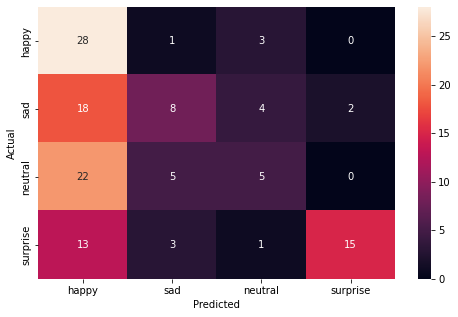

In [ ]:
evaluate_model(Efficientnetmodel, folder_path, set_name = "test", batch_size = 128, img_size = 48,
               preprocessing_function = EffNet_pp, color_mode = 'rgb')

## **MobileNet Model**

Dissatisfied with the performance of the first three transfer learning models (ResNet and EfficientNet in particular), I attempted to perform transfer learning with a different model called MobileNet (version 2).  I picked MobileNet because its description mentions good performance on face attributes:

> **MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications**

>We present a class of efficient models called MobileNets for mobile and embedded vision applications. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. We introduce two simple global hyper-parameters that efficiently trade off between latency and accuracy. These hyper-parameters allow the model builder to choose the right sized model for their application based on the constraints of the problem. We present extensive experiments on resource and accuracy tradeoffs and show strong performance compared to other popular models on ImageNet classification. We then demonstrate the effectiveness of MobileNets across a wide range of applications and use cases including object detection, finegrain classification, **face attributes** and large scale geo-localization.

> Source: ([https://arxiv.org/abs/1704.04861](https://arxiv.org/abs/1704.04861)

I build the MobileNet model in the same manner as those above, but spare the reader a narration of each individual step (save for some comments in the code).

In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as ap
from tensorflow.keras import Model
MobileNet = ap.MobileNetV2(include_top=False, weights="imagenet", input_shape= (48, 48, 3), alpha=1.4)

MobileNet.summary()

# Note: Researching the warning message below revealed that it is not something to be
# concerned about - the model works fine with various input shapes, according to
# neural network discussion forums.

17831080/17831080 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.40_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 48)   1296        ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 48)   192         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 48)   0           ['bn_Conv1[0][0]']               
              

In [ ]:
# I recreated the make_dataflow function here to make it easier to change
# data augmentation parameters

# Create a function to make the flow-from-directory data streams for each set.
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as MobNet_pp

def make_dataflow(folder_path, set_name, img_size = 48, color_mode = 'rgb',
                  shear_range = 0,
                  batch_size = 32, class_mode = 'categorical',
                  classes = ['happy', 'sad', 'neutral', 'surprise'],
                  preprocessing_function = None,
                  shuffle = True):
  generator = ImageDataGenerator(horizontal_flip = True,
                                 rotation_range=30,
                                 brightness_range = (0., 2.),
                                 rescale = 1./255,
                                 # shear_range = shear_range,
                                 zoom_range=0.2,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 fill_mode='reflect',
                                 preprocessing_function = preprocessing_function)
  return generator.flow_from_directory(folder_path + set_name,
                                              target_size = (img_size, img_size),
                                              color_mode = color_mode,
                                              batch_size = batch_size,
                                              class_mode = class_mode,
                                              classes = classes,
                                              shuffle = shuffle)


In [ ]:
if MobileNetModel: del MobileNetModel
reset_backend()

In [ ]:
# Build model

#transfer_layer_MobileNet = MobileNet.get_layer('out_relu')
transfer_layer_MobileNet = MobileNet.get_layer('block_10_project_BN')

MobileNet.trainable = False

# Classification network
x = Flatten()(transfer_layer_MobileNet.output)
x = Dense(1728, activation = 'relu')(x)
x = Dense(864, activation = 'relu')(x)
x = Dense(432, activation = 'relu')(x)
x = Dense(216, activation = 'relu')(x)

# Prediction layer
pred = Dense(4, activation = 'softmax')(x)

MobileNetModel = Model(MobileNet.input, pred)

MobileNetModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 24, 24, 48)   1296        ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 24, 24, 48)   192         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 24, 24, 48)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Mobilenetmodel.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 30

In [ ]:
MobileNetModel.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
# Modify dataset preprocessing

from tensorflow.keras.applications.mobilenet import preprocess_input as MobNet_pp

train_set = make_dataflow(folder_path, "train", batch_size = 64, shear_range = 0,
                          preprocessing_function = None)
validation_set = make_dataflow(folder_path, "validation", batch_size = 64, shear_range = 0,
                               preprocessing_function = None)
test_set = make_dataflow(folder_path, "test", batch_size = 128, 
                          preprocessing_function = None, shuffle = False)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


In [ ]:
history_mob = MobileNetModel.fit(train_set, validation_data=validation_set, epochs = epochs, verbose=1, callbacks = callbacks_list)


Epoch 1/30
237/237 [==============================] - ETA: 0s - loss: 1.2271 - accuracy: 0.4836
Epoch 1: val_accuracy improved from -inf to 0.55917, saving model to ./Mobilenetmodel.h5
237/237 [==============================] - 69s 125ms/step - loss: 1.2271 - accuracy: 0.4836 - val_loss: 1.0250 - val_accuracy: 0.5592 - lr: 0.0010
Epoch 2/30
237/237 [==============================] - ETA: 0s - loss: 1.0446 - accuracy: 0.5488
Epoch 2: val_accuracy improved from 0.55917 to 0.56339, saving model to ./Mobilenetmodel.h5
237/237 [==============================] - 29s 122ms/step - loss: 1.0446 - accuracy: 0.5488 - val_loss: 1.0260 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 3/30
237/237 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.5590
Epoch 3: val_accuracy improved from 0.56339 to 0.58851, saving model to ./Mobilenetmodel.h5
237/237 [==============================] - 29s 121ms/step - loss: 1.0221 - accuracy: 0.5590 - val_loss: 0.9791 - val_accuracy: 0.5885 - lr: 0.001

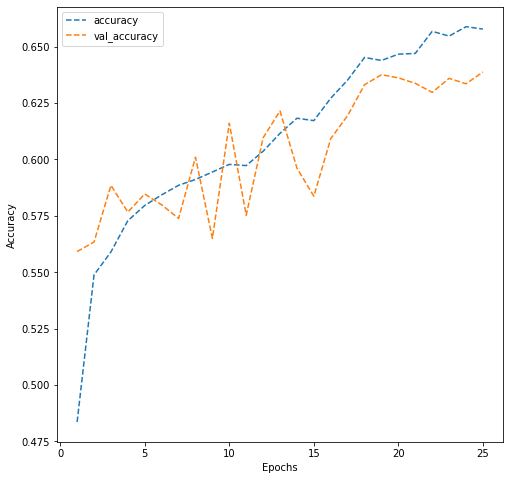

In [ ]:
# Plot training accuracy
plot_training_acc(history_mob)

Found 4977 images belonging to 4 classes.
156/156 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1825
           1       0.58      0.50      0.54      1139
           2       0.55      0.56      0.55      1216
           3       0.66      0.74      0.70       797

    accuracy                           0.64      4977
   macro avg       0.63      0.63      0.63      4977
weighted avg       0.64      0.64      0.64      4977



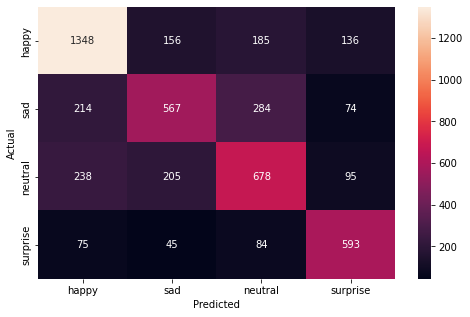

In [ ]:
# Run MobileNet model on validation set and show results
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as MobNet_pp

evaluate_model(MobileNetModel, folder_path, set_name = "validation", batch_size = 4977, img_size = 48,
               preprocessing_function = None, color_mode = 'rgb')

#### **Optimizing the MobileNet model**

I made the initial architecture of the MobileNet model very simple: a single dense layer of 1000 nodes followed by the classificaiton layer.  The following list shows changes that I attempted to improve the model's performance.  The percentage after each change is the model's accuracy on the validation set after making the change.  Changes that decreased the model's performance were discarded unless otherwise noted.

*   Initial attempt: 49%
*   Added MobileNet preprocessing: 25%
*   Removed all but softmax layer: 47%
*   Added one dense layer (512): 49%
*   Added BatchNorm and another dense (256): 48%
*   Reduced nodes in dense layers: 47%
*   Changed activation to relu: 47% (looked like it could go higher with longer training)
*   Increase nodes by 100%: 47%
*   Reduced batch sizes to 64: 47%
*   Reduced learning rate to 0.0001, increased stopping patience to 5, increased epochs to 30: 49%
*   Moved transfer layer to block_15_add: 51%
*   Moved transfer layer to block_12_add: 53%
*   Moved transfer layer to block_9_add: 48%
*   Moved transfer layer to block_11_add: 54%
*   Moved transfer layer to block_10_project_BN: 54%
*   Changed optimizer to RMSprop: 52%
*   Changed optimizer to SGD: 50%
*   Changed optimizer to Adagrad: 51%
*   Reduced learning rate to 0.0005: 54%
*   Increased stopping patience to 5: 55%
*   Reduced number of nodes by 20%: 54%
*   Increased number of nodes by 20%: 55%
*   Increased number of nodes by 20%: 55%
*   Increased number of nodes by 20%: 55%
*   Increased number of nodes to 1024: 55%
*   Incraesed number of nodes to 2048: 56%
*   Same num. params but added dense layer (550:275): 55%
*   As above but made two equal sized layers (400:400): 55%
*   Reversed order (275:550): 55%
*   Incressed number of nodes to 4096: 57%
*   Increased number of nodes to 8192: 57%
*   Copied VGG16 classification layer: 62%
*   Doubled nodes: 64%
*   Added another dense layer to end: 64%
*   Reduced shear range to 0.1: 63%
*   Increased sheer range to 0.5: 64%
*   Added 45 degree rotations: 60%
*   Reduced rotation to 30, raised learning rate to 0.001, added zoom_range=0.2: 61%
*   Reduced batch size to 64, added dense layer to end: 62%
*   Removed shear: 62%
*   Moved transfer layer to block_12_add: 60%
*   Added width_shift_range=0.1, height_shift_range=0.1: 63% (still ascending when it reached epoch limit)
*   Reduced stopping patience to 3, added fill_mode='reflect': 64%
*   Changed flatten() to GlobalAvgPooling: 52%
*   Experimenting with new architecture (1728 nodes in first layer (2x the flattened layer), then halfing it N times before the classification layer where N ranges from 0-5; N = 0 (also increased patience to 4): 63%
*   N = 0, added BN layer before classification: 62%
*   N = 0, added Drop(0.3) layer before classification: 60%
*   N = 1: 64%
*   N = 2: 64%
*   N = 3: 64%
*   N = 4: 64%
*   N = 5: 64%
*   N = 3, added BN to middle: 63%
*   N = 3, added BN to end: 61%
*   N = 3, added BN to beginning: 64% (reached max epoch, both curves still increasing)
*   N = 3, added Dropout(0.3) after BN: 64% (reached max epoch, both curves still increasing)
*   N = 3, changed activation fn to sigmoid: 61%
*   N = 3, changed activation to leaky relu (0.1): 64%
*   N = 3, increased leaky relu alpha to 0.2: 64%
*   N = 3, increased leaky relu alpha to 0.3: 64%
*   N = 3, removing leaky relu, increasing epochs to 40: 63%
*   N = 3, removed Dropout and BN layers, increased patience to 5, decreased learning rate to 0.0005: 64%
*   N = 3, increased learning rate to 0.001: 64%
*   N = 3, increased patience to 6: 64% (final model)

**Observations:** After extensive optimization I was able to improve the model's performance from an initial accuracy of 49% on the validation set to 64%.  The most beneificial changes were moving the transfer layer upstream to block 11 and copying the architecture of the VGG16 final model.

On the test set, the model achieved a 69% accuracy.  The worst category was Neutral, at 57%.  The Sad accuracy was next worst at 65%, but this is somewhat better than the VGG16's (the best performing transfer learning model) score of 59%.  However, this number should be taken with caution as the model only scored a 54% accuracy in the Sad category on the validation set.

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        32
           1       0.78      0.56      0.65        32
           2       0.54      0.59      0.57        32
           3       0.82      0.72      0.77        32

    accuracy                           0.69       128
   macro avg       0.70      0.69      0.69       128
weighted avg       0.70      0.69      0.69       128



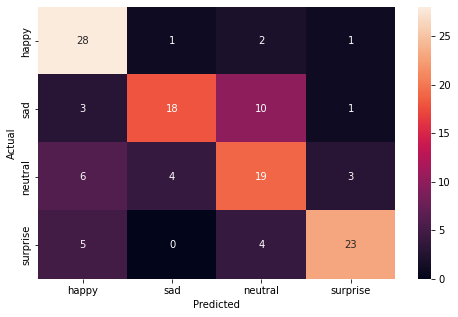

In [ ]:
# Evaluate model on the test set
evaluate_model(MobileNetModel, folder_path, set_name = "test", batch_size = 128, img_size = 48,
               preprocessing_function = None, color_mode = 'rgb')

## **Conclusions**

Emotion detection from static images is not an easy problem to solve.  Large pre-trained networks that were trained as general image classifiers do not appear to help solve the problem, though further testing could improve those results.  One possible explanation for this is that the networks we tested were trained on color images, and the images we are seeking to classify are grayscale.

Another reason transfer learning did not perform well here could be due to key differences between the classes the transferred networks were tought to distinguish and the classes we need to separate here.  A search of the [1000 classes in imagenet](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/) did not find any emotion words (e.g., happy, sad, surprised) nor any words describing people (e.g., woman, child, baby).  All of the classes on imagenet are physical objects or animals, like "goose" and "castle".  We are trying to distinguish very similar images from each other, and much of the subtle differences we care about may not be detected by networks trained to classify grossly different things.

The de novo CNNs performed better than the transfer learning models.  Among the CNNs, the best model contained by far the most parameters, and had an architecture that bulged (in terms of numbers of parameters) in the middle and was tapered at the input and output ends.



### Hypothetical business application
#### Distinguish between Happy, Surprised, and [Neutral or Sad]

All models tested had difficulty distinguishing between Sad and Neutral.  This is not surprising, as those facial expressions can be very similar.

This does not mean the models are not useful, however.  There are many possible applications in which distinguishing between Happy, Surprised, and EITHER Sad/Neutral (as one group) could be useful.  For example, if monitoring audience faces during a movie screening to find which scenes are most impactful, knowing when the audience is happy or surprised could be useful for deciding which parts to keep during the editing process.

If we group together Sad and Neutral, model performance improves dramatically.  The below code shows this.

Found 128 images belonging to 4 classes.
4/4 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        32
           1       0.91      0.95      0.93        64
           3       0.97      0.88      0.92        32

    accuracy                           0.91       128
   macro avg       0.91      0.89      0.90       128
weighted avg       0.91      0.91      0.91       128



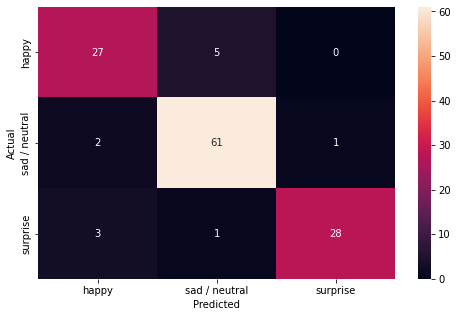

In [ ]:
# Get predicted and true vectors for test set
data_set = make_dataflow(folder_path, "test", color_mode = "grayscale",
                           batch_size = 128,
                           shuffle = False)
  
data_images, data_labels = next(data_set)

# Get predicted classes and true classes
pred = model3.predict(data_images)
pred = np.argmax(pred, axis = 1) 
y_true = np.argmax(data_labels, axis = 1)

# Replace "2" (class Neutral) with "1" (class Sad/Neutral) in both vectors
pred_modified = pred[:]
true_modified = y_true[:]
pred_modified[pred_modified == 2] = 1
true_modified[true_modified == 2] = 1

# Print the classification report
print(classification_report(true_modified, pred_modified))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(true_modified, pred_modified)
plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', 
            xticklabels = ['happy', 'sad / neutral', 'surprise'], 
            yticklabels = ['happy', 'sad / neutral', 'surprise'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:** When we combine the Sad and Neutral categories, the final model gives very good performance for all three emotions, ranging from an F1 score of 84% for Happy to 93% for the combined Sad / Neutral group.  This model would be very good for business use cases in which distinguishing between Sad and Neutral was not important.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Revised_Version_of_Micheal_Cary_Facial_Emotion_Detection_Milestone_2.ipynb

[NbConvertApp] Converting notebook /content/Revised_Version_of_Micheal_Cary_Facial_Emotion_Detection_Milestone_2.ipynb to html
[NbConvertApp] Writing 1181713 bytes to /content/Revised_Version_of_Micheal_Cary_Facial_Emotion_Detection_Milestone_2.html
